&nbsp;
<div style="text-align: center;">

## <span style="color: black;">Website SuperClassics - Europe Classic Cars</span>

&nbsp;

![SuperClassics Logo](superclassics_logo.png)

&nbsp;

### <span style="color: black;">Gartner Analysis</span>

#### <span style="color: #003E99"> *41 Brands, 944 suppliers* </font> </span>

## Index

- [<font color='black'> 1. Packages installation</font>](#1)

- [<font color='black'> 2. Data importation</font>](#2)

- [<font color='black'> 3. Data Normalization (Min-Max)</font>](#3)
      
- [<font color='black'> 4. Clustering </font>](#4)
    - [<font color='black'> 4.1. Elbow method </font>](#4.1)
    - [<font color='black'> 4.2. Silhouette plot and value </font>](#4.2)
    - [<font color='black'> 4.3. Final model </font>](#4.3)



## 1. Packages installation
<a id='1'>

In [1]:
#!pip3 install yellowbrick
#!pip3 install scipy

In [2]:
# dataframe
import pandas as pd

# array
import numpy as np

# normalization
from sklearn.preprocessing import MinMaxScaler

# graph
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from sklearn.cluster import KMeans

#Metrics
from yellowbrick.cluster import silhouette_visualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score
from scipy import stats


## 2. Data importation
<a id='2'>

In [3]:
db0 = pd.read_csv('Suppliers_factors')

In [4]:
db0.head()

,Brand,MostProducedCountry,Carbon_footprint_mean,Supplier_quantity,Google Hits,Carbon_footprint_mean_log,Google Hits_log,Supplier_quantity_log
0,AC,Australia,1044.000000,4,137000000,6.950815,18.735491,1.386294
1,Abarth,Belgium,1028.833333,4,24700000,6.936181,17.022314,1.386294
2,Alfa Romeo,Netherlands,720.161765,63,52800000,6.579476,17.782022,4.143135
3,Allard,United States,1002.000000,1,1890000,6.909753,14.452087,0.000000
4,Alvis,United Kingdom,1305.000000,5,3620000,7.173958,15.101985,1.609438


In [5]:
#remove brands not known
db0 = db0[~db0['Brand'].isin(['Glas','Mini','AC','American Brands','British Brands',
                              'Classic Car Dealer','Customs and Hot Rods', 'East German Brands', 
                              'European Brands','French Brands', 'German Brands',
                             'Italian Brands', 'Japanese Brands','Kitcars', 'Military Vehicles',
                             'Pre-War Cars', 'Prestige and Supercars', 'Race and rally cars',
                             'Russian Brands', 'Trucks and Trailers','Ford (USA)','Youngtimers', 'Caterham','Packard',
                             'Trabant', 'Studebaker', 'TVR','Hillman', 'Marcos','TVR'])]

In [6]:
list = db0['Brand'].unique().tolist()
print(list)

['Abarth', 'Alfa Romeo', 'Allard', 'Alvis', 'Aston Martin', 'Austin', 'BMW', 'Bentley', 'Bugatti', 'Buick', 'Cadillac', 'Chevrolet', 'Chrysler', 'Citroën', 'DKW', 'Daimler', 'Datsun', 'De Tomaso', 'Facel Vega', 'Ferrari', 'Fiat', 'Ford', 'Holden', 'Lancia', 'Land Rover', 'Lotus', 'MG', 'Maserati', 'Mazda', 'Morgan', 'Morris', 'NSU', 'Opel', 'Panhard', 'Peugeot', 'Pontiac', 'Porsche', 'Range Rover', 'Reliant', 'Renault', 'Riley', 'Rover', 'Saab', 'Simca', 'Subaru', 'Toyota', 'Triumph', 'Volkswagen', 'Škoda']


In [7]:
len(list)

49

In [8]:
db0.rename(columns={'Supplier_quantity': 'Supplier_tot'}, inplace=True)

## 3.  Data Normalization (Min-Max)
<a id='3'>

<span style='color:blue'> Choose the Top X Google Hits

In [9]:
db = db0.sort_values(by='Google Hits', ascending=False).head(100)

In [10]:
#db = db0.sort_values(by='Google Hits', ascending=False).head(20)

In [11]:
db.reset_index(drop=True, inplace=True)

In [12]:
db1 = db.copy()
columns_to_normalize = ['Supplier_tot', 'Carbon_footprint_mean']

# MinMax
scaler = MinMaxScaler(feature_range=(0,1))
db2 = pd.DataFrame(scaler.fit_transform(db1[columns_to_normalize]),columns=[col + '_mm' for col in columns_to_normalize])

# new columns
db1 = pd.concat([db1, db2], axis=1)
db1.head()

,Brand,MostProducedCountry,Carbon_footprint_mean,Supplier_tot,Google Hits,Carbon_footprint_mean_log,Google Hits_log,Supplier_quantity_log,Supplier_tot_mm,Carbon_footprint_mean_mm
0,Ford,Germany,843.933333,15,225000000,6.738074,19.231611,2.708050,0.065728,0.296804
1,BMW,Germany,713.313725,51,183000000,6.569921,19.024997,3.931826,0.234742,0.239364
2,Toyota,Germany,560.500000,4,170000000,6.328829,18.951309,1.386294,0.014085,0.172164
3,Volkswagen,Germany,831.708609,157,131000000,6.723482,18.690708,5.056246,0.732394,0.291429
4,Porsche,Germany,693.765258,214,125000000,6.542134,18.643824,5.365976,1.000000,0.230767


## 4. Clustering 
<a id='4'>

### 4.1. Elbow method
<a id='4.1'>

C:\Users\InesC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\InesC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\InesC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\InesC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

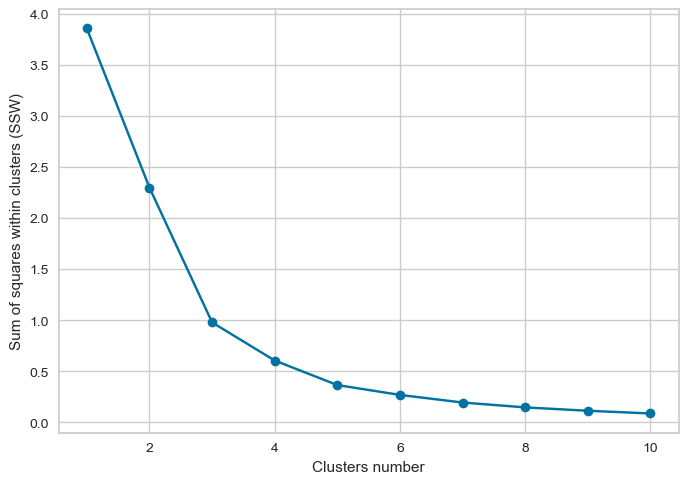

In [13]:
data = db1[['Supplier_tot_mm', 'Carbon_footprint_mean_mm']]

cost = []

for num_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=num_clusters, n_init=10)
    kmeans.fit(data)
    cost.append(kmeans.inertia_)

plt.plot(range(1, 11), cost, marker='o')
plt.xlabel('Clusters number')
plt.ylabel('Sum of squares within clusters (SSW)')
plt.savefig('Modelling_CO2_qtdSuppliers_elbow_maxsamplesize.eps')
plt.savefig('Modelling_CO2_qtdSuppliers_elbow_maxsamplesize.png')
plt.show()


<span style='color:blue'> The elbow method shows that data should be split in four ou five clusters, according to the inflection point equal to four.

### 4.2. Silhouette plot and value
<a id='4.2'>

C:\Users\InesC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\InesC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\InesC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\InesC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

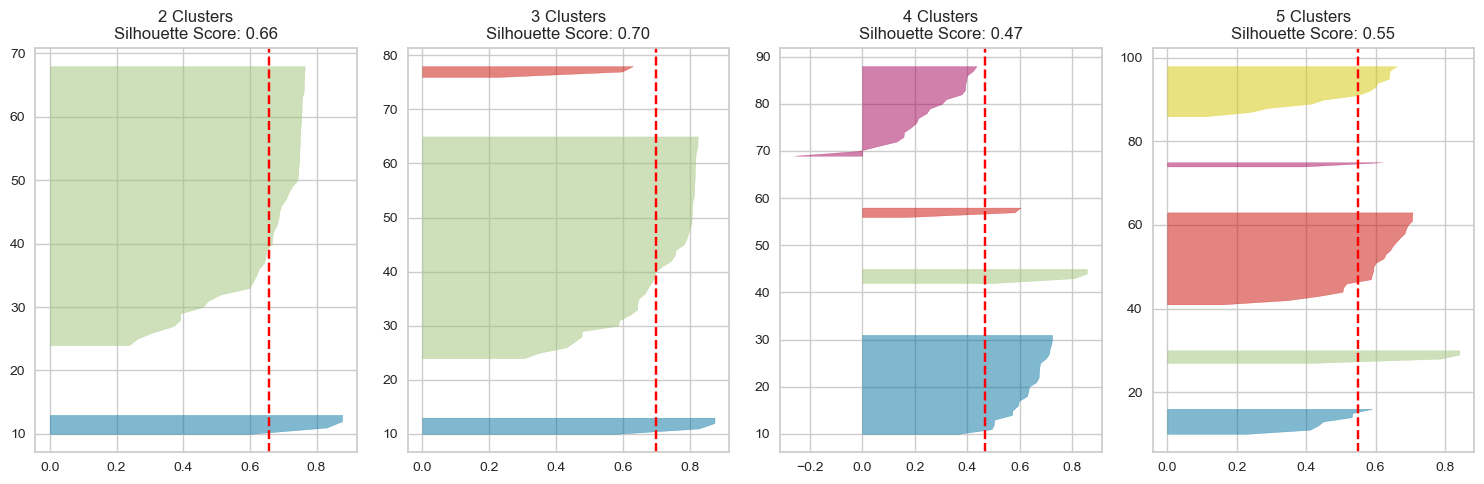

In [14]:
#data
X = db1[['Supplier_tot_mm', 'Carbon_footprint_mean_mm']]

#number of clusters to try
clusters_list = [2, 3, 4, 5]

#graph
fig, axs = plt.subplots(1, len(clusters_list), figsize=(15, 5))
silhouette_scores = []
for ax, n_clusters in zip(axs, clusters_list):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    # graph
    visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax)
    # adjust data to model
    visualizer.fit(X)
    labels = kmeans.labels_
    # Silhoette score
    silhouette_avg = silhouette_score(X, labels)
    silhouette_scores.append(silhouette_avg)
    # title with number of clusters and score
    ax.set_title(f'{n_clusters} Clusters\nSilhouette Score: {silhouette_avg:.2f}')

plt.tight_layout()
plt.savefig('Modelling_CO2_qtdSuppliers_silhouette_plots_maxsamplesize.eps')
plt.savefig('Modelling_CO2_qtdSuppliers_silhouette_plots_maxsamplesize.png')
plt.show()


<span style='color:blue'> From the data distribution results for each cluster group (2, 3, 4, or 5) and the silhouette score it is possible to verify that the best data distribution is made with three clusters (silhouette score = 0.57).


### 4.3. Final model
<a id='4.3'>

C:\Users\InesC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\InesC\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\InesC\AppData\Local\Temp\ipykernel_2180\3307098604.py:53: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  circle = plt.Circle((centroids[cluster_label, 1], centroids[cluster_label, 0]),
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


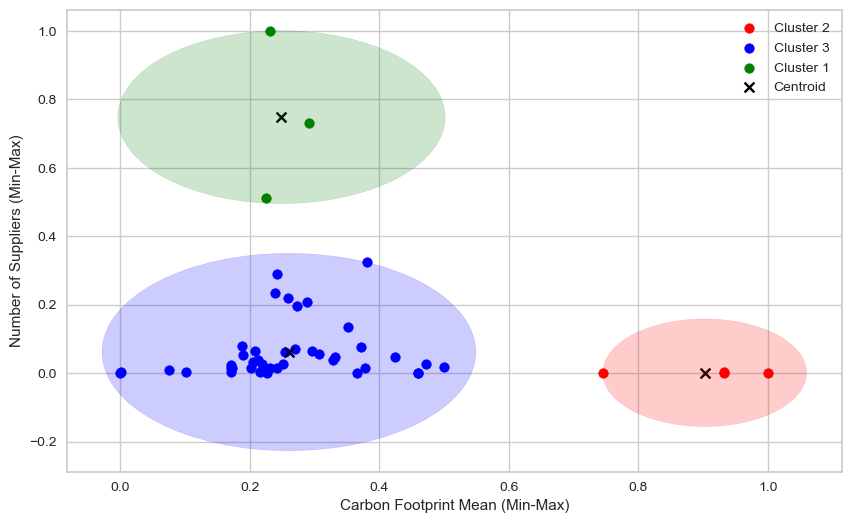

In [15]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

data = db1[['Supplier_tot_mm', 'Carbon_footprint_mean_mm']]

num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters)

kmeans.fit(data)

db1['Cluster'] = kmeans.labels_

centroids = kmeans.cluster_centers_

cluster_sizes = db1['Cluster'].value_counts()

min_cluster = cluster_sizes.idxmin()
max_cluster = cluster_sizes.idxmax()

colors = {}
for cluster_label in range(num_clusters):
    if cluster_label == min_cluster:
        colors[cluster_label] = 'green'
    elif cluster_label == max_cluster:
        colors[cluster_label] = 'blue'
    else:
        colors[cluster_label] = 'red'

plt.figure(figsize=(10, 6))
for cluster_label in range(num_clusters):
    cluster_data = db1[db1['Cluster'] == cluster_label]
    
    if cluster_label == 0:
        label = 'Cluster 2'
    elif cluster_label == 1:
        label = 'Cluster 3'
    else:
        label = 'Cluster 1'

    plt.scatter(cluster_data['Carbon_footprint_mean_mm'], cluster_data['Supplier_tot_mm'], 
                label=label, color=colors[cluster_label])  

plt.scatter(centroids[:, 1], centroids[:, 0], s=50, c='black', marker='x', label='Centroid')

for cluster_label in range(num_clusters):
    cluster_data = db1[db1['Cluster'] == cluster_label]
    distances = np.sqrt((cluster_data['Carbon_footprint_mean_mm'] - centroids[cluster_label, 1]) ** 2 +
                        (cluster_data['Supplier_tot_mm'] - centroids[cluster_label, 0]) ** 2)
    max_distance = distances.max()
    
    circle = plt.Circle((centroids[cluster_label, 1], centroids[cluster_label, 0]), 
                        max_distance, color=colors[cluster_label], alpha=0.2, fill=True, edgecolor='black')
    plt.gca().add_patch(circle)

plt.xlabel('Carbon Footprint Mean (Min-Max)')
plt.ylabel('Number of Suppliers (Min-Max)')
plt.legend()
plt.savefig('Modelling_CO2_qtdSupplier_clustering_maxsamplesize.eps', dpi=300, transparent=True)
plt.savefig('Modelling_CO2_qtdSupplier_clustering_maxsamplesize.png', dpi=300, transparent=True)
plt.show()


In [16]:
# cluster results

db1['Cluster'] = kmeans.labels_
result_table = db1[['Brand', 'Supplier_tot_mm', 'Carbon_footprint_mean_mm', 'Cluster']]
result_table['Cluster'] = result_table['Cluster'].replace({0: 2, 1: 3, 2: 1})
print(result_table)


           Brand  Supplier_tot_mm  Carbon_footprint_mean_mm  Cluster
0           Ford         0.065728                  0.296804        3
1            BMW         0.234742                  0.239364        3
2         Toyota         0.014085                  0.172164        3
3     Volkswagen         0.732394                  0.291429        1
4        Porsche         1.000000                  0.230767        1
5      Chevrolet         0.197183                  0.273412        3
6             MG         0.323944                  0.380444        3
7        Ferrari         0.206573                  0.287685        3
8         Morgan         0.065728                  0.208267        3
9          Mazda         0.037559                  0.327763        3
10       Renault         0.028169                  0.218620        3
11         Rover         0.028169                  0.471353        3
12       Peugeot         0.032864                  0.204870        3
13       Triumph         0.136150 

C:\Users\InesC\AppData\Local\Temp\ipykernel_2180\1621131336.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  result_table['Cluster'] = result_table['Cluster'].replace({0: 2, 1: 3, 2: 1})


In [126]:
db1['Cluster'] = db1['Cluster'].replace({0: 2, 1: 3, 2: 1})

In [17]:
from scipy import stats

anova_supplier_tot = stats.f_oneway(
    db1[db1['Cluster'] == 1]['Supplier_tot_mm'],
    db1[db1['Cluster'] == 2]['Supplier_tot_mm'],
    db1[db1['Cluster'] == 3]['Supplier_tot_mm']
)

anova_carbon_footprint = stats.f_oneway(
    db1[db1['Cluster'] == 1]['Carbon_footprint_mean_mm'],
    db1[db1['Cluster'] == 2]['Carbon_footprint_mean_mm'],
    db1[db1['Cluster'] == 3]['Carbon_footprint_mean_mm']
)

print(f"ANOVA Supplier Total: F-value = {anova_supplier_tot.statistic}, p-value = {anova_supplier_tot.pvalue}")
print(f"ANOVA Carbon Footprint Mean: F-value = {anova_carbon_footprint.statistic}, p-value = {anova_carbon_footprint.pvalue}")


ANOVA Supplier Total: F-value = nan, p-value = nan
ANOVA Carbon Footprint Mean: F-value = nan, p-value = nan


C:\Users\InesC\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4133: DegenerateDataWarning: at least one input has length 0
  warnings.warn(stats.DegenerateDataWarning('at least one input '


In [18]:
def sum_of_squares(data, global_mean=None):
    if global_mean is None:
        global_mean = data.mean()
    return ((data - global_mean) ** 2).sum()

num_clusters = db1['Cluster'].nunique()

results = {'Supplier_tot_mm': {}, 'Carbon_footprint_mean_mm': {}}

global_mean_supplier_tot = db1['Supplier_tot_mm'].mean()
global_mean_carbon = db1['Carbon_footprint_mean_mm'].mean()

sst_supplier_tot = sum_of_squares(db1['Supplier_tot_mm'], global_mean_supplier_tot)
sst_carbon = sum_of_squares(db1['Carbon_footprint_mean_mm'], global_mean_carbon)

ssb_supplier_tot = 0
ssb_carbon = 0

for cluster in range(1, num_clusters + 1):
    db_cluster = db1[db1['Cluster'] == cluster]
    cluster_size = len(db_cluster)
    
    if cluster_size > 0:
        cluster_mean_supplier_tot = db_cluster['Supplier_tot_mm'].mean()
        cluster_mean_carbon = db_cluster['Carbon_footprint_mean_mm'].mean()
        
        ssb_supplier_tot += cluster_size * (cluster_mean_supplier_tot - global_mean_supplier_tot) ** 2
        ssb_carbon += cluster_size * (cluster_mean_carbon - global_mean_carbon) ** 2

ssw_supplier_tot = sst_supplier_tot - ssb_supplier_tot
ssw_carbon = sst_carbon - ssb_carbon

dfb = num_clusters - 1
dfw_supplier_tot = len(db1) - num_clusters
dfw_carbon = len(db1) - num_clusters

if dfw_supplier_tot > 0 and dfw_carbon > 0:
    msb_supplier_tot = ssb_supplier_tot / dfb
    msw_supplier_tot = ssw_supplier_tot / dfw_supplier_tot
    msb_carbon = ssb_carbon / dfb
    msw_carbon = ssw_carbon / dfw_carbon

    results['Supplier_tot_mm'] = {
        'SST': sst_supplier_tot, 'SSB': ssb_supplier_tot, 'SSW': ssw_supplier_tot, 'MSB': msb_supplier_tot, 'MSW': msw_supplier_tot
    }
    results['Carbon_footprint_mean_mm'] = {
        'SST': sst_carbon, 'SSB': ssb_carbon, 'SSW': ssw_carbon, 'MSB': msb_carbon, 'MSW': msw_carbon
    }

    for variable, metrics in results.items():
        print(f"\nResultados para {variable}:")
        print(f"  SST = {metrics['SST']:.4f}")
        print(f"  SSB = {metrics['SSB']:.4f}")
        print(f"  SSW = {metrics['SSW']:.4f}")
        print(f"  MSB = {metrics['MSB']:.4f}")
        print(f"  MSW = {metrics['MSW']:.4f}")
else:
    print("Os graus de liberdade para a Soma dos Quadrados Dentro dos Grupos não são válidos.")



Resultados para Supplier_tot_mm:
  SST = 1.7620
  SSB = 1.3224
  SSW = 0.4397
  MSB = 0.6612
  MSW = 0.0096

Resultados para Carbon_footprint_mean_mm:
  SST = 2.0941
  SSB = 0.1242
  SSW = 1.9700
  MSB = 0.0621
  MSW = 0.0428


In [147]:
import pandas as pd

# Função para calcular Soma dos Quadrados
def sum_of_squares(data, global_mean=None):
    if global_mean is None:
        global_mean = data.mean()
    return ((data - global_mean) ** 2).sum()

# Número de clusters
num_clusters = db1['Cluster'].nunique()

# Inicializar dicionários para armazenar os resultados
results = {'Supplier_tot_zscore': {}, 'Carbon_footprint_mean_zscore': {}}

# Média global das variáveis
global_mean_supplier_tot = db1['Supplier_tot_zscore'].mean()
global_mean_carbon = db1['Carbon_footprint_mean_zscore'].mean()

# Iterar sobre cada cluster e variável
for cluster in range(1, num_clusters + 1):  # Ajustado para clusters numerados de 1 a 3
    db_cluster = db1[db1['Cluster'] == cluster]
    cluster_size = len(db_cluster)
    
    if cluster_size > 0:
        # Calcular a média do cluster para as variáveis
        cluster_mean_supplier_tot = db_cluster['Supplier_tot_zscore'].mean()
        cluster_mean_carbon = db_cluster['Carbon_footprint_mean_zscore'].mean()
        
        # Calcular Soma dos Quadrados Total (SST) para o cluster
        sst_supplier_tot = sum_of_squares(db_cluster['Supplier_tot_zscore'], cluster_mean_supplier_tot)
        sst_carbon = sum_of_squares(db_cluster['Carbon_footprint_mean_zscore'], cluster_mean_carbon)
        
        # Calcular Soma dos Quadrados Dentro dos Grupos (SSW) para o cluster
        ssw_supplier_tot = sst_supplier_tot
        ssw_carbon = sst_carbon
        
        # Calcular Soma dos Quadrados Entre Grupos (SSB) para cada variável
        cluster_means_supplier_tot = db1.groupby('Cluster')['Supplier_tot_zscore'].mean()
        cluster_means_carbon = db1.groupby('Cluster')['Carbon_footprint_mean_zscore'].mean()
        
        ssb_supplier_tot = sum_of_squares(cluster_means_supplier_tot, global_mean_supplier_tot)
        ssb_carbon = sum_of_squares(cluster_means_carbon, global_mean_carbon)
        
        # Ajustar SSB para refletir o tamanho do cluster
        ssb_supplier_tot *= cluster_size / len(db1)
        ssb_carbon *= cluster_size / len(db1)
        
        # Calcular SSW ajustado para o cluster atual
        ssw_supplier_tot -= ssb_supplier_tot / num_clusters
        ssw_carbon -= ssb_carbon / num_clusters
        
        # Calcular Graus de Liberdade
        dfb = num_clusters - 1
        dfw_supplier_tot = len(db1) - num_clusters
        dfw_carbon = len(db1) - num_clusters
        
        # Verificar se os graus de liberdade são válidos
        if dfw_supplier_tot > 0 and dfw_carbon > 0:
            # Calcular Média dos Quadrados (MSB e MSW)
            msb_supplier_tot = ssb_supplier_tot / dfb
            msw_supplier_tot = ssw_supplier_tot / dfw_supplier_tot
            msb_carbon = ssb_carbon / dfb
            msw_carbon = ssw_carbon / dfw_carbon

            # Armazenar os resultados
            results['Supplier_tot_zscore'][f'Cluster {cluster}'] = {
                'SST': sst_supplier_tot, 'SSB': ssb_supplier_tot, 'SSW': ssw_supplier_tot, 'MSB': msb_supplier_tot, 'MSW': msw_supplier_tot
            }
            results['Carbon_footprint_mean_zscore'][f'Cluster {cluster}'] = {
                'SST': sst_carbon, 'SSB': ssb_carbon, 'SSW': ssw_carbon, 'MSB': msb_carbon, 'MSW': msw_carbon
            }
        else:
            print(f"Graus de liberdade inválidos para o cluster {cluster}.")
    else:
        print(f"Cluster {cluster} não contém dados suficientes.")

# Exibir os resultados organizados
for variable, clusters in results.items():
    print(f"\nResultados para {variable}:")
    for cluster, metrics in clusters.items():
        print(f"{cluster}:")
        print(f"  SST = {metrics['SST']:.4f}")
        print(f"  SSB = {metrics['SSB']:.4f}")
        print(f"  SSW = {metrics['SSW']:.4f}")
        print(f"  MSB = {metrics['MSB']:.4f}")
        print(f"  MSW = {metrics['MSW']:.4f}")



Resultados para Supplier_tot_zscore:
Cluster 1:
  SST = 0.1196
  SSB = 0.0265
  SSW = 0.1107
  MSB = 0.0132
  MSW = 0.0024
Cluster 2:
  SST = 0.2820
  SSB = 0.3707
  SSW = 0.1584
  MSB = 0.1853
  MSW = 0.0034
Cluster 3:
  SST = 0.0000
  SSB = 0.0353
  SSW = -0.0118
  MSB = 0.0177
  MSW = -0.0003

Resultados para Carbon_footprint_mean_zscore:
Cluster 1:
  SST = 0.0027
  SSB = 0.0217
  SSW = -0.0045
  MSB = 0.0109
  MSW = -0.0001
Cluster 2:
  SST = 0.5385
  SSB = 0.3041
  SSW = 0.4371
  MSB = 0.1521
  MSW = 0.0095
Cluster 3:
  SST = 0.0361
  SSB = 0.0290
  SSW = 0.0264
  MSB = 0.0145
  MSW = 0.0006
